# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [687]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [1]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [2]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [3]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [4]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

dirpath = './dataset/IIIT-CFW/'
X1,y1 = load_data(dirpath)
N1,H,W = X1.shape[0:3]
C = 1 if opt['is_grayscale'] else X1.shape[3]

dirpath = './dataset/Yale_face_database/'
X2,y2 = load_data(dirpath)
N2,H,W = X2.shape[0:3]
C = 1 if opt['is_grayscale'] else X2.shape[3]


Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


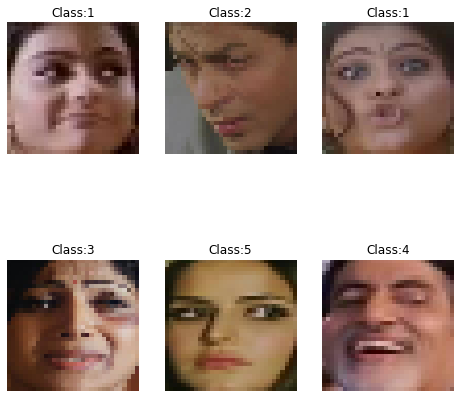

In [5]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

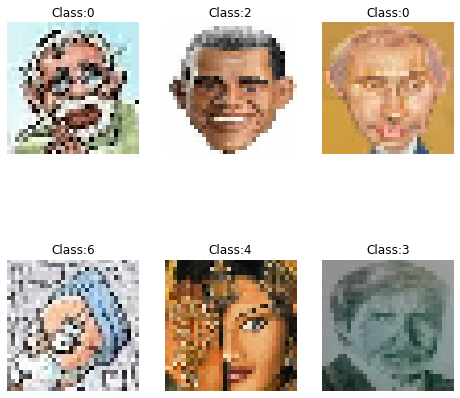

In [6]:
ind1 = np.random.randint(0,y1.shape[0],6)
disply_images(X1[ind1,...],y1[ind], row=2,col=3)

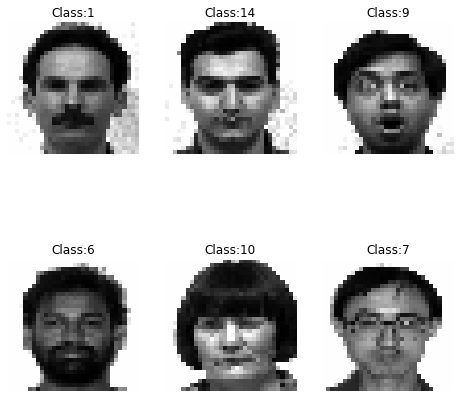

In [7]:
ind2 = np.random.randint(0,y2.shape[0],6)
disply_images(X2[ind2,...],y2[ind2], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [8]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [9]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k, pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [10]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k, kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [11]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k, lda


### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [12]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k, klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [13]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [14]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

If all possible sets of valid faces lie in an n dimensional space, eigenfaces are the set of vectors that form a basis spanning an m dimensional sub-space (m < n)
used to represent all those possible sets. It is
based on the assumption that all possible faces lie in a low-dimensional sub-space which can be
efficiently represented as a linear combination of the eigenvectors of the covariance matrix of all the faces.


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [15]:
# Compute your features 
# eg.4
# X_3D = get_kernel_lda(X,y,3)
X_3D, _ = get_pca(X,169)

X1 = X1.reshape((N1,H*W*C))
X1_3D, _ = get_pca(X1,400)


X2 = X2.reshape((N2,H*W*C))
X2_3D, _ = get_pca(X2,75)

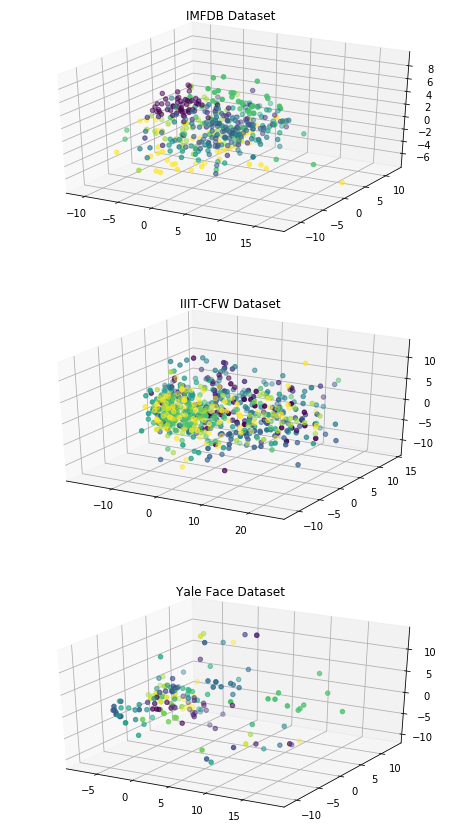

In [16]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,15))

ax = fig.add_subplot(311, projection='3d')
ax.set_title("IMFDB Dataset")
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)

ax = fig.add_subplot(312, projection='3d')
ax.set_title("IIIT-CFW Dataset")
ax.scatter(X1_3D[:,0],X1_3D[:,1],X1_3D[:,2],c=y1)

ax = fig.add_subplot(313, projection='3d')
ax.set_title("Yale Face Dataset")
ax.scatter(X2_3D[:,0],X2_3D[:,1],X2_3D[:,2],c=y2)
plt.show()

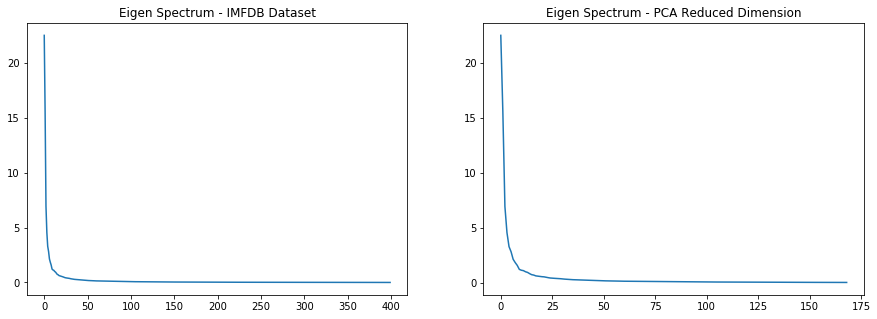

Variance preserved in IMFDB dataset with 169 eigenfaces:  0.9699865417618129


In [17]:
# Plot the eigen value spectrum 
pca = PCA()
pca.fit_transform(X)
eigen_val = pca.explained_variance_

pca1 = PCA(n_components=169)
pca1.fit_transform(X)
num = pca1.components_
eigen_val1 = pca1.explained_variance_

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Eigen Spectrum - IMFDB Dataset")
plt.plot(eigen_val)
plt.subplot(122)
plt.title("Eigen Spectrum - PCA Reduced Dimension")
plt.plot(eigen_val1)
plt.show()
print("Variance preserved in IMFDB dataset with 169 eigenfaces: ", np.sum(eigen_val1)/np.sum(eigen_val))

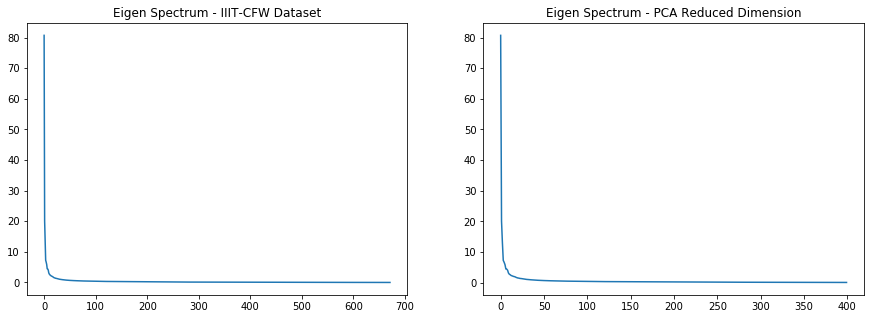

Variance preserved in IIIT CFW dataset with 400 eigen faces:  0.9752121078448853


In [18]:
pca = PCA()
pca.fit_transform(X1)
eigen_val = pca.explained_variance_

pca2 = PCA(n_components=400)
pca2.fit_transform(X1)
num = pca2.components_
eigen_val1 = pca2.explained_variance_

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Eigen Spectrum - IIIT-CFW Dataset")
plt.plot(eigen_val)
plt.subplot(122)
plt.title("Eigen Spectrum - PCA Reduced Dimension")
plt.plot(eigen_val1)
plt.show()
print("Variance preserved in IIIT CFW dataset with 400 eigen faces: ", np.sum(eigen_val1)/np.sum(eigen_val))

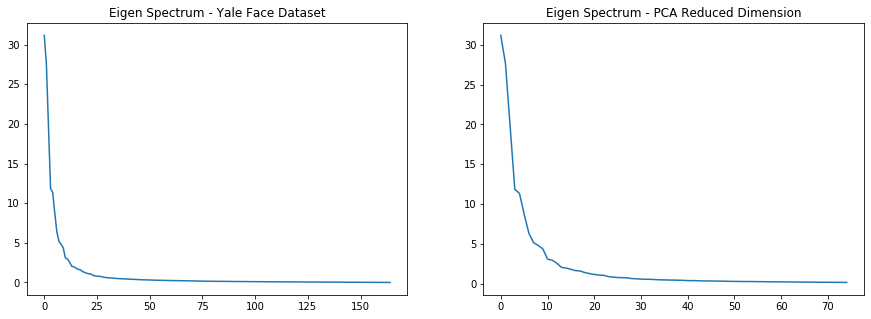

Variance preserved in IMFDB dataset with 75 eigenfaces:  0.9651252122675195


In [19]:
pca = PCA()
pca.fit_transform(X2)
eigen_val = pca.explained_variance_

pca3 = PCA(n_components=75)
pca3.fit_transform(X2)
num = pca3.components_
eigen_val1 = pca3.explained_variance_

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Eigen Spectrum - Yale Face Dataset")
plt.plot(eigen_val)
plt.subplot(122)
plt.title("Eigen Spectrum - PCA Reduced Dimension")
plt.plot(eigen_val1)
plt.show()
print("Variance preserved in IMFDB dataset with 75 eigenfaces: ", np.sum(eigen_val1)/np.sum(eigen_val))

1. For IMFDB, eigen vectors corresponding to the largest 169 eigen values preserve 97% variance. 
2. For CFW, eigen vectors corresponding to the largest 400 eigen values preserve 97.5% variance. 
3. For Yale Face Dataset, eigen vectors corresponding to the largest 169 eigen values preserve 96.5% variance.

1(c). Reconstruct  the  image  back for each case


In [20]:
def reconstruct_images(X_proj, pca, N, H, W):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    X_inv_proj = pca.inverse_transform(X_proj)
    reconstruct_X = np.reshape(X_inv_proj,(N,H,W,3))

    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMFDB Reconstructed Images


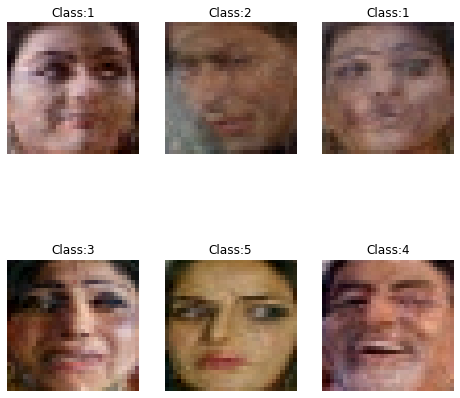

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IIIT CFW Reconstructed Images


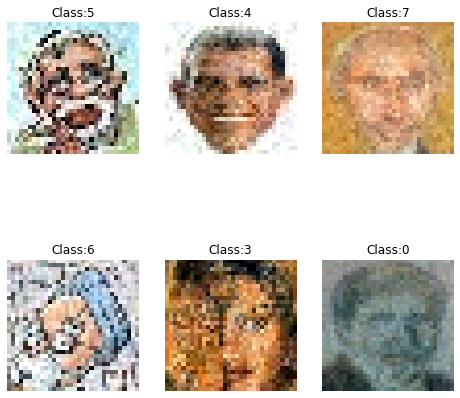

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Yale Face Reconstructed Images


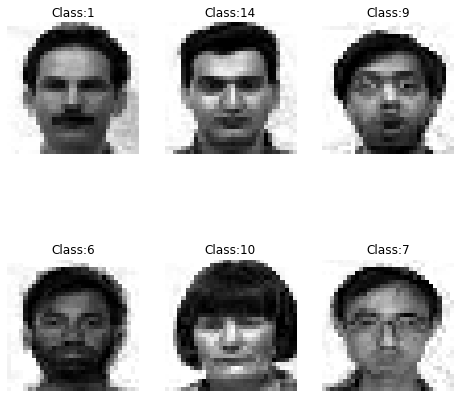

Reconstruction Error for IMFDB:  4.178482932441447
Reconstruction Error for IIIT CFW:  8.291073057074156
Reconstruction Error for Yale Face:  5.879276831460899


In [21]:
# Display results 
print("IMFDB Reconstructed Images")
X_reconstructed = reconstruct_images(X_3D, pca1, N, H, W)
disply_images(X_reconstructed[ind,...],y[ind],row=2,col=3)
X = np.reshape(X,(N,H,W,3))

print("IIIT CFW Reconstructed Images")
X1_reconstructed = reconstruct_images(X1_3D, pca2, N1, H, W)
disply_images(X1_reconstructed[ind1,...],y1[ind1],row=2,col=3)
X1 = np.reshape(X1,(N1,H,W,3))

print("Yale Face Reconstructed Images")
X2_reconstructed = reconstruct_images(X2_3D, pca3, N2, H, W)
disply_images(X2_reconstructed[ind2,...],y2[ind2],row=2,col=3)
X2 = np.reshape(X2,(N2,H,W,3))

# Show the reconstruction error
print("Reconstruction Error for IMFDB: ", np.sqrt(np.mean((X - X_reconstructed)**2))*100)
print("Reconstruction Error for IIIT CFW: ", np.sqrt(np.mean((X1 - X1_reconstructed)**2))*100)
print("Reconstruction Error for Yale Face: ", np.sqrt(np.mean((X2 - X2_reconstructed)**2))*100)

Reconstruction Error for IMFDB:  4.372505867576119 <br>
Reconstruction Error for IIIT CFW:  8.004718183590663 <br>
Reconstruction Error for Yale Face: 5.761531862968221 <br>

CFW dataset has the highest reconstruction error which makes it difficult to represent this dataset using fewer eigen vectors(as can be seen from the eigen spectrum). 

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

Class with maximum error :  2
Class with maximum error : 2, Error = 4.333254159008703
Person difficult to represent with fewer eigen vectors in IMFDB belongs to class 2: SharukhKhan


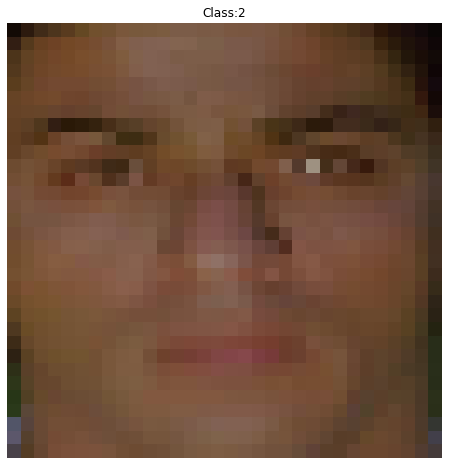

Class with maximum error : 1, Error = 8.57883793469337
Person difficult to represent with fewer eigen vectors in CFW belongs to class 1: AamirKhan


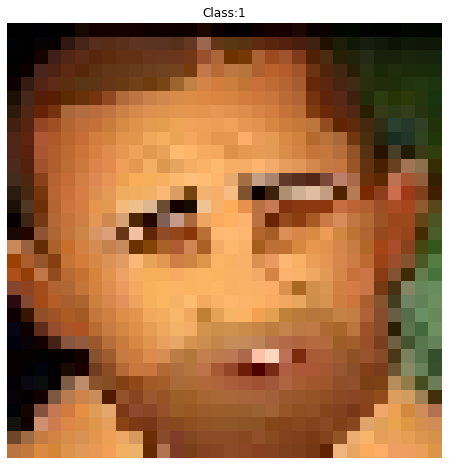

Class with maximum error : 0, Error = 6.644182312140597
Person difficult to represent with fewer eigen vectors in Yale database belongs to class 0: 


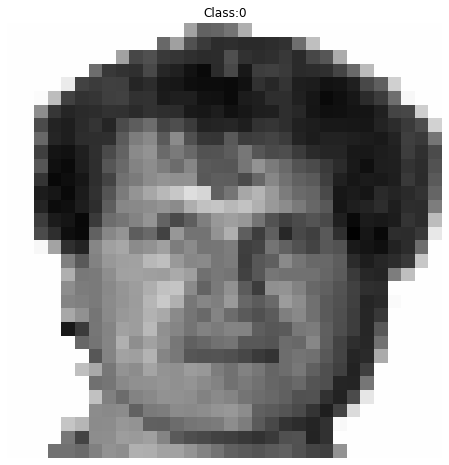

In [22]:
# code goes here
mse = []
for i in np.unique(y):
    error = np.sqrt(np.mean((X[y == i] - X_reconstructed[y == i])**2))
    mse.append(error)
class1 = np.argmax(np.array(mse))
print("Class with maximum error : ", class1)
print("Class with maximum error : {}, Error = {}".format(class1, np.max(np.array(mse))*100))
for name, value in imfdb_dict.items():
    if value == class1:
        print("Person difficult to represent with fewer eigen vectors in IMFDB belongs to class {}: {}".format(class1,name))
Xnew = X[y==class1]
ynew = y[y == class1]
disply_images(Xnew[:1], ynew[:1], row=1, col=1)

mse = []
for i in np.unique(y1):
    error = np.sqrt(np.mean((X1[y1 == i] - X1_reconstructed[y1 == i])**2))
    mse.append(error)
class1 = np.argmax(np.array(mse))
print("Class with maximum error : {}, Error = {}".format(class1, np.max(np.array(mse))*100))

for name, value in cfw_dict.items():
    if value == class1:
        print("Person difficult to represent with fewer eigen vectors in CFW belongs to class {}: {}".format(class1,name))
Xnew = X1[y1==class1]
ynew = y1[y1 == class1]
disply_images(Xnew[:1], ynew[:1], row=1, col=1)

mse = []
for i in np.unique(y2):
    error = np.sqrt(np.mean((X2[y2 == i] - X2_reconstructed[y2 == i])**2))
    mse.append(error)
class1 = np.argmax(np.array(mse))
print("Class with maximum error : {}, Error = {}".format(class1, np.max(np.array(mse))*100))
Xnew = X2[y2==class1]
ynew = y2[y2 == class1]
print("Person difficult to represent with fewer eigen vectors in Yale database belongs to class {}: ".format(class1))
disply_images(Xnew[:1], ynew[:1], row=1, col=1)

To find out the person/identity is difficult to represent compactly with fewer eigen vectors, we look at the maximum reconstruction error among all the images in the dataset.The more the error, the harder it is to represent that image with eigenfaces. 

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [46]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

class Classifier():
    def __init__(self, typ):
#         super.__init__()
        if typ == 'MLP':
            self.classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
        elif typ == 'LR':
            self.classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
        elif typ == 'SVM':
            self.classifier = svm.SVC(gamma='scale')
        elif typ == 'DT':
            self.classifier = DecisionTreeClassifier(random_state=0)
        
    
    # Define your parameters eg, W,b, max_iterations etc.
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
            
        """
        
        prediction = self.classifier.predict(X)
        
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = confusion_matrix(pred, y)
        return cm
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        return self.classifier.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        
        # Create a confusion matrix
        y_pred = self.classifier.predict(X_validate)
        
        cm = confusion_matrix(y_pred, y_validate)
        
        # Calculate Validation accuracy 
        diagonal_sum = cm.trace()
        sum_of_all_elements = cm.sum()
        accuracy = diagonal_sum / sum_of_all_elements
        
        # Calculate precision and recall 
        precision = precision_score(y_validate, y_pred, average=None) 
        recall = recall_score(y_validate, y_pred, average=None)  
        
        # Calculate F1-score
        f1score = f1_score(y_validate, y_pred, average='weighted')
    
        return cm, accuracy, precision, recall, f1score

In [47]:
# Create a train and validation split to train your classifier 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
from sklearn.model_selection import train_test_split
X = X.reshape((N,H*W*C))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Dataset shape: (400, 32, 32, 3)


In [48]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)
from IPython.display import display, HTML
df = pd.DataFrame(columns=['Method', 'Reduced Space', 'Classification Error', 'Accuracy', 'F1-Score'])

#PCA + MLP
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[1] = ['PCA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

#'KPCA + MLP'
X_proj_train, kpca = get_kernel_pca(X_train, 200)
X_proj_test = kpca.transform(X_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[2] = ['KPCA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

#LDA + MLP
X_proj_train, lda = get_lda(X_train, y_train, 100)
X_proj_test = lda.transform(X_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[3] = ['LDA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

#KLDA + MLP
X_proj_train, klda = get_kernel_lda(X_train, y_train, 100)
X_proj_test = klda.transform(X_test)
c = Classifier('SVM')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[4] = ['KLDA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

# PCA + LDA + LR
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 100)
X_proj_test = lda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[5] = ['PCA + LDA + LR', X_proj_train.shape[1], 1-a, a, f1]

# PCA + KPCA + LR
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 100)
X_proj_test = kpca.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[6] = ['PCA + KPCA + LR', X_proj_train.shape[1] , 1-a, a, f1]

# LDA + KLDA + LR
X_proj_train, lda = get_lda(X_train, y_train, 200)
X_proj_test = lda.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 100)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[7] = ['LDA + KLDA + LR', X_proj_train.shape[1] , 1-a, a, f1]

# KPCA + KLDA + LR
X_proj_train, kpca = get_kernel_pca(X_train, 200)
X_proj_test = kpca.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 100)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[8] = ['KPCA + KLDA + LR', X_proj_train.shape[1] , 1-a, a, f1]


# PCA + KPCA + LDA + KLDA + LR
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 100)
X_proj_test = kpca.transform(X_proj_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 75)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 50)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[9] = ['PCA + KPCA + LDA + KLDA + LR', X_proj_train.shape[1] , 1-a, a, f1]

#PCA + LDA + LDA + MLP
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 100)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 75)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[10] = ['PCA + LDA + KLDA + MLP', X_proj_train.shape[1] , 1-a, a, f1]


#VGG + LR
X_proj = get_vgg_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[11] = ['VGG + LR', X_proj_train.shape[1] , 1-a, a, f1]

#resnet + LR
X_proj = get_resnet_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = Classifier('LR')
c.train(X_proj_train, y_train)
cm1, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[12] = ['Resnet + LR', X_proj_train.shape[1] , 1-a, a, f1]

print(df)
df.to_csv("IMFDB.csv")


/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


                          Method Reduced Space  Classification Error  \
1                      PCA + MLP           200              0.159091   
2                     KPCA + MLP           200              0.295455   
3                      LDA + MLP             7              0.272727   
4                     KLDA + MLP             7              0.272727   
5                 PCA + LDA + LR             7              0.204545   
6                PCA + KPCA + LR           100              0.318182   
7                LDA + KLDA + LR             7              0.265152   
8               KPCA + KLDA + LR             7              0.181818   
9   PCA + KPCA + LDA + KLDA + LR             7              0.136364   
10        PCA + LDA + KLDA + MLP             7              0.219697   
11                      VGG + LR          4096              0.090909   
12                   Resnet + LR          2048              0.045455   

    Accuracy  F1-Score  
1   0.840909  0.840669  
2   0.704545 

/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [49]:
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

X = X.reshape((N,H*W*C))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
df = pd.DataFrame(columns=['Method', 'Reduced Space', 'Classification Error', 'Accuracy', 'F1-Score'])

X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[1] = ['PCA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

X_proj_train, kpca = get_kernel_pca(X_train, 400)
X_proj_test = kpca.transform(X_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[2] = ['KPCA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

X_proj_train, lda = get_lda(X_train, y_train, 400)
X_proj_test = lda.transform(X_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[3] = ['LDA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

X_proj_train, klda = get_kernel_lda(X_train, y_train, 400)
X_proj_test = klda.transform(X_test)
c = Classifier('SVM')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[4] = ['KLDA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

# PCA + LDA + LR
X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 200)
X_proj_test = lda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[5] = ['PCA + LDA + LR', X_proj_train.shape[1], 1-a, a, f1]

# PCA + KPCA + LR
X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 200)
X_proj_test = kpca.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[6] = ['PCA + KPCA + LR', X_proj_train.shape[1] , 1-a, a, f1]

# LDA + KLDA + LR
X_proj_train, lda = get_lda(X_train, y_train, 400)
X_proj_test = lda.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 200)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[7] = ['LDA + KLDA + LR', X_proj_train.shape[1] , 1-a, a, f1]

# KPCA + KLDA + LR
X_proj_train, kpca = get_kernel_pca(X_train, 400)
X_proj_test = kpca.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 200)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[8] = ['KPCA + KLDA + LR', X_proj_train.shape[1] , 1-a, a, f1]


# PCA + KPCA + LDA + KLDA + LR
X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 350)
X_proj_test = kpca.transform(X_proj_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 300)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 200)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[9] = ['PCA + KPCA + LDA + KLDA + LR', X_proj_train.shape[1] , 1-a, a, f1]

#PCA + LDA + LDA + MLP
X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 200)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 150)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[10] = ['PCA + LDA + KLDA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

#VGG + LR
X_proj = get_vgg_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[11] = ['VGG + LR', X_proj_train.shape[1] , 1-a, a, f1]

#resnet + LR
X_proj = get_resnet_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = Classifier('LR')
c.train(X_proj_train, y_train)
cm2, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[12] = ['Resnet + LR', X_proj_train.shape[1] , 1-a, a, f1]


df.to_csv("IIIT-CSV.csv")
print(df)


Dataset shape: (672, 32, 32, 3)


/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


                          Method Reduced Space  Classification Error  \
1                      PCA + MLP           400              0.504505   
2                     KPCA + MLP           400              0.531532   
3                      LDA + MLP             7              0.671171   
4                     KLDA + MLP             7              0.684685   
5                 PCA + LDA + LR             7              0.590090   
6                PCA + KPCA + LR           200              0.509009   
7                LDA + KLDA + LR             7              0.626126   
8               KPCA + KLDA + LR             7              0.527027   
9   PCA + KPCA + LDA + KLDA + LR             7              0.432432   
10        PCA + LDA + KLDA + MLP             7              0.581081   
11                      VGG + LR          4096              0.319820   
12                   Resnet + LR          2048              0.036036   

    Accuracy  F1-Score  
1   0.495495  0.493797  
2   0.468468 

/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [50]:
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

X = X.reshape((N,H*W*C))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
df = pd.DataFrame(columns=['Method', 'Reduced Space', 'Classification Error', 'Accuracy', 'F1-Score'])

X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[1] = ['PCA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

X_proj_train, kpca = get_kernel_pca(X_train, 75)
X_proj_test = kpca.transform(X_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[2] = ['KPCA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

X_proj_train, lda = get_lda(X_train, y_train, 75)
X_proj_test = lda.transform(X_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[3] = ['LDA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

X_proj_train, klda = get_kernel_lda(X_train, y_train, 75)
X_proj_test = klda.transform(X_test)
c = Classifier('SVM')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[4] = ['KLDA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

# PCA + LDA + LR
X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 50)
X_proj_test = lda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
cm31, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[5] = ['PCA + LDA + LR', X_proj_train.shape[1], 1-a, a, f1]

# PCA + KPCA + LR
X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 50)
X_proj_test = kpca.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[6] = ['PCA + KPCA + LR', X_proj_train.shape[1] , 1-a, a, f1]

# LDA + KLDA + LR
X_proj_train, lda = get_lda(X_train, y_train, 75)
X_proj_test = lda.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 50)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[7] = ['LDA + KLDA + LR', X_proj_train.shape[1] , 1-a, a, f1]

# KPCA + KLDA + LR
X_proj_train, kpca = get_kernel_pca(X_train, 75)
X_proj_test = kpca.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 50)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[8] = ['KPCA + KLDA + LR', X_proj_train.shape[1] , 1-a, a, f1]


# PCA + KPCA + LDA + KLDA + LR
X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 50)
X_proj_test = kpca.transform(X_proj_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 30)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 25)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[9] = ['PCA + KPCA + LDA + KLDA + LR', X_proj_train.shape[1] , 1-a, a, f1]

#PCA + LDA + LDA + MLP
X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 50)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 25)
X_proj_test = klda.transform(X_proj_test)
c = Classifier('MLP')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[10] = ['PCA + LDA + KLDA + MLP', X_proj_train.shape[1] , 1-a, a, f1]

#VGG + LR
X_proj = get_vgg_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = Classifier('LR')
c.train(X_proj_train, y_train)
_, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[11] = ['VGG + LR', X_proj_train.shape[1] , 1-a, a, f1]

#resnet + LR
X_proj = get_resnet_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = Classifier('LR')
c.train(X_proj_train, y_train)
cm32, a,precision, recall, f1 = c.validate(X_proj_test, y_test)
df.loc[12] = ['Resnet + LR', X_proj_train.shape[1] , 1-a, a, f1]


df.to_csv("Yale_face.csv")
print(df)


Dataset shape: (165, 32, 32, 3)


/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/li

                          Method Reduced Space  Classification Error  \
1                      PCA + MLP            75              0.200000   
2                     KPCA + MLP            75              0.090909   
3                      LDA + MLP            14              0.054545   
4                     KLDA + MLP            14              0.054545   
5                 PCA + LDA + LR            14              0.000000   
6                PCA + KPCA + LR            50              0.327273   
7                LDA + KLDA + LR            14              0.036364   
8               KPCA + KLDA + LR            14              0.018182   
9   PCA + KPCA + LDA + KLDA + LR            14              0.272727   
10        PCA + LDA + KLDA + MLP            14              0.090909   
11                      VGG + LR          4096              0.381818   
12                   Resnet + LR          2048              0.000000   

    Accuracy  F1-Score  
1   0.800000  0.804591  
2   0.909091 

/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [28]:
# For each dataset print the confusion matrix for the best model 
print('FOR IMFDB: Best Model - Resnet + LR, Accuracy: 95.45%')
print('Confusion Matrix: ', cm1, '\n')

print('FOR IIIT-CFW Model - Resnet + LR, Accuracy: 96.4%')
print('Confusion Matrix: ', cm2, '\n')

print('FOR Yale Faces: Best Model - PCA + LDA + LR and Resnet + LR, Accuracy: 100%')
print('Confusion Matrix for PCA + LDA + LR: ', cm31, '\n')
print('Confusion Matrix for Resnet + LR: ', cm32, '\n')

FOR IMFDB: Best Model - Resnet + LR, Accuracy: 95.45%
Confusion Matrix:  [[15  0  0  0  0  0  0  0]
 [ 1 11  0  0  0  0  2  1]
 [ 0  0 13  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0]
 [ 0  0  0  0 17  0  0  0]
 [ 0  1  0  0  0 15  0  0]
 [ 0  0  0  0  1  0 18  0]
 [ 0  0  0  0  0  0  0 18]] 

FOR IIIT-CFW Model - Resnet + LR, Accuracy: 96.4%
Confusion Matrix:  [[12  0  1  1  0  0  0  0]
 [ 0 15  0  0  0  0  0  1]
 [ 0  0 30  0  0  0  0  0]
 [ 0  0  0 42  0  0  0  0]
 [ 1  1  0  0 32  0  0  0]
 [ 0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 21  0]
 [ 1  0  0  0  1  1  0 38]] 

FOR Yale Faces: Best Model - PCA + LDA + LR and Resnet + LR, Accuracy: 100%
Confusion Matrix for PCA + LDA + LR:  [[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0

### IMFDB
Resnet + LR gives the best accuracy. As seen in the confusion matrix, only 5 of the samples are misclassified hence leading to larger accuracy. <br>
### CFW dataset
Resnet + LR gives the best accuracy. As seen in the confusion matrix, only 5 of the samples are misclassified hence leading to larger accuracy. <br>
### Yale Face 
Resnet + LR and PCA + LDA + LR give the best accuracy. As seen in the confusion matrices for both the cases, none of the samples are misclassified hence leading to an accuracy of 100%. <br>

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

Dataset shape: (400, 32, 32, 3)


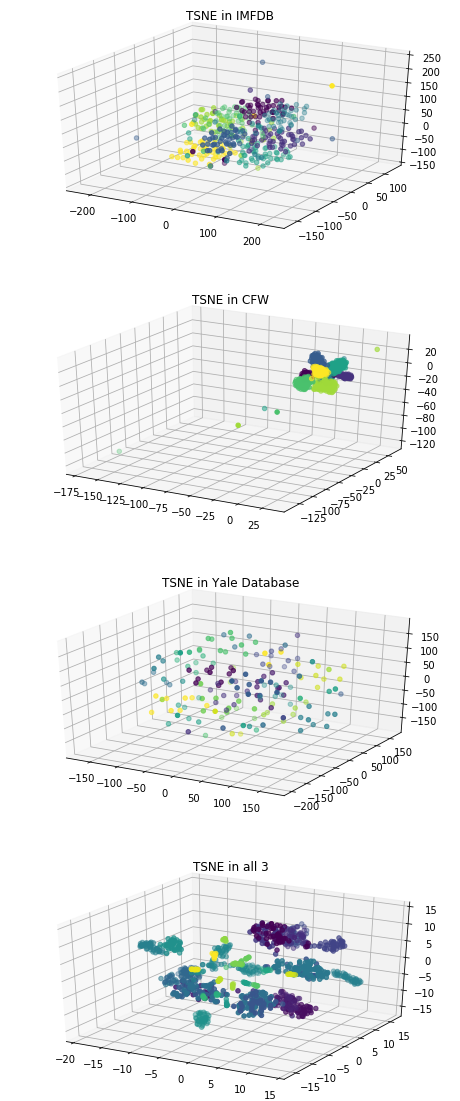

In [33]:
# Compute TSNE for different features and create a scatter plot
# from sklearn.manifold import TSNE
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))

X_new = get_resnet_features(dirpath) # feature 
k = 3 
dirpath = './dataset/IIIT-CFW/'
X1_new = get_resnet_features(dirpath) # feature 

dirpath = './dataset/Yale_face_database/'
X2_new = get_resnet_features(dirpath) # feature 

X3_new = np.concatenate((X1_new, np.concatenate((X_new, X2_new))))

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(X_new)
X1_TSNE = TSNE(n_components=k).fit_transform(X1_new)
X2_TSNE = TSNE(n_components=k).fit_transform(X2_new)
X3_TSNE = TSNE(n_components=k).fit_transform(X3_new)


fig = plt.figure(figsize=(8,20))
ax = fig.add_subplot(411, projection='3d')
ax.set_title('TSNE in IMFDB')
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], X_TSNE[:,2],c=y)

ax = fig.add_subplot(412, projection='3d')
ax.set_title('TSNE in CFW')
ax.scatter(X1_TSNE[:,0], X1_TSNE[:,1], X1_TSNE[:,2],c=y1)

ax = fig.add_subplot(413, projection='3d')
ax.set_title('TSNE in Yale Database')
ax.scatter(X2_TSNE[:,0], X2_TSNE[:,1], X2_TSNE[:,2],c=y2)

ax = fig.add_subplot(414, projection='3d')
ax.set_title('TSNE in all 3')
ax.scatter(X3_TSNE[:,0], X3_TSNE[:,1], X3_TSNE[:,2],c=np.hstack((y, y1+8,y2+16)))
plt.show()

### IMF Dataset
We can see some distinct clustering of classes
showing that datapoints that were close together in the original feature space are still closer in the
3D dimensional feature space although classes are well separated. <br>

### CFW Dataset
We can see that the samples in each class in the 3D dimen-
sional space are still well-clustered in the reduced dimension, hence the feature transformation is but all the clusters seem to be very close to each other. <br>

### Yale Face Dataset
We can see that there is no apparent clustering/grouping of samples. This
shows that the samples in the reduced dimension might not be an accurate representation of the
samples in the original space. <br>

### All the three datasets
We see that it forms a clusters in 3D space corresponding to
the different classes in each of the datasets.

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN <br>
Given the face image and an arbitrary class ID. We can perform KNN on the image
using the complete dataset. If the majority of the k-nearest neighbors of the image have the class ID same as the one given, the response is a “Yes” otherwise it's a “No”.

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task. <br>

Verification error gives the percentage of false predictions among all the predictions. So verification error of the classfier along with the precision and accuracy are used to analyze the performance of the classifer.

4(c)Show empirical re-sults  with  all  the  representations

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

class FaceVerification():
    def __init__(self):
#         super.__init__()
        self.classifier = KNeighborsClassifier(n_neighbors=3)
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        pred = self.classifier.predict(X)
        if pred == class_id:
            verification_results = True
        else:
            verification_results = False
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        return self.classifier.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        y_pred = self.classifier.predict(X_validate)
        accuracy = accuracy_score(y_validate, y_pred)
        
        
        verify = np.count_nonzero(y_pred != y_validate)
        verify = verify/y_pred.shape[0]
        
        precision = precision_score(y_validate, y_pred, average='weighted')
        
        return verify, accuracy, precision

In [52]:
# Create a train and validation split and show your results 
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
from sklearn.model_selection import train_test_split
X = X.reshape((N,H*W*C))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Dataset shape: (400, 32, 32, 3)


In [53]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)

df = pd.DataFrame(columns=['Method', 'Reduced Space', 'Verification Error', 'Accuracy', 'Precision'])

#PCA + KNN
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[1] = ['PCA + KNN', X_proj_train.shape[1] , a, v, p]

# PCA + LDA + KNN
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 100)
X_proj_test = lda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[2] = ['PCA + LDA + KNN', X_proj_train.shape[1] , a, v, p]

# PCA + KPCA + KNN
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 100)
X_proj_test = kpca.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[3] = ['PCA + KPCA + KNN', X_proj_train.shape[1] , a, v, p]

# LDA + KLDA + KNN
X_proj_train, lda = get_lda(X_train, y_train, 200)
X_proj_test = lda.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 100)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[4] = ['LDA + KLDA + KNN', X_proj_train.shape[1] , a, v, p]

# KPCA + KLDA + KNN
X_proj_train, kpca = get_kernel_pca(X_train, 200)
X_proj_test = kpca.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 100)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[5] = ['KPCA + KLDA + KNN', X_proj_train.shape[1] , a, v, p]


# PCA + KPCA + LDA + KLDA + KNN
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 100)
X_proj_test = kpca.transform(X_proj_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 75)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 50)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[6] = ['PCA + KPCA + LDA + KLDA + KNN', X_proj_train.shape[1] , a, v, p]

#PCA + LDA + KNN
X_proj_train, pca = get_pca(X_train, 200)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 100)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 75)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[7] = ['PCA + LDA + KNN', X_proj_train.shape[1] , a, v, p]

#VGG + LR
X_proj = get_vgg_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[8] = ['VGG + KNN', X_proj_train.shape[1] , a, v, p]

#resnet + LR
X_proj = get_resnet_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[9] = ['Resnet + KNN', X_proj_train.shape[1] , a, v, p]

df.to_csv("IMFDB-KNN.csv")

print(df)

/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


                          Method Reduced Space  Verification Error  Accuracy  \
1                      PCA + KNN           200            0.507576  0.492424   
2                PCA + LDA + KNN             7            0.219697  0.780303   
3               PCA + KPCA + KNN           100            0.424242  0.575758   
4               LDA + KLDA + KNN             7            0.295455  0.704545   
5              KPCA + KLDA + KNN             7            0.196970  0.803030   
6  PCA + KPCA + LDA + KLDA + KNN             7            0.159091  0.840909   
7                PCA + LDA + KNN             7            0.227273  0.772727   
8                      VGG + KNN          4096            0.098485  0.901515   
9                   Resnet + KNN          2048            0.053030  0.946970   

   Precision  
1   0.658932  
2   0.844092  
3   0.692879  
4   0.762777  
5   0.854842  
6   0.850316  
7   0.833672  
8   0.903597  
9   0.961722  


In [54]:
dirpath = './dataset/IIIT-CFW/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

df = pd.DataFrame(columns=['Method', 'Reduced Space', 'Verification Error', 'Accuracy', 'Precision'])

#PCA + KNN
X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[1] = ['PCA + KNN', X_proj_train.shape[1] , a, v, p]

# PCA + LDA + KNN
X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 200)
X_proj_test = lda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[2] = ['PCA + LDA + KNN', X_proj_train.shape[1] , a, v, p]

# PCA + KPCA + KNN
X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 200)
X_proj_test = kpca.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[3] = ['PCA + KPCA + KNN', X_proj_train.shape[1] , a, v, p]

# LDA + KLDA + KNN
X_proj_train, lda = get_lda(X_train, y_train, 400)
X_proj_test = lda.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 200)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[4] = ['LDA + KLDA + KNN', X_proj_train.shape[1] , a, v, p]

# KPCA + KLDA + KNN
X_proj_train, kpca = get_kernel_pca(X_train, 400)
X_proj_test = kpca.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 200)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[5] = ['KPCA + KLDA + KNN', X_proj_train.shape[1] , a, v, p]


# PCA + KPCA + LDA + KLDA + KNN
X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 200)
X_proj_test = kpca.transform(X_proj_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 150)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 100)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[6] = ['PCA + KPCA + LDA + KLDA + KNN', X_proj_train.shape[1] , a, v, p]

#PCA + LDA + KNN
X_proj_train, pca = get_pca(X_train, 400)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 200)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 150)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[7] = ['PCA + LDA + KNN', X_proj_train.shape[1] , a, v, p]

#VGG + LR
X_proj = get_vgg_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[8] = ['VGG + KNN', X_proj_train.shape[1] , a, v, p]

#resnet + LR
X_proj = get_resnet_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[9] = ['Resnet + KNN', X_proj_train.shape[1] , a, v, p]


df.to_csv("IIIT-CFW-KNN.csv")

print(df)

Dataset shape: (672, 32, 32, 3)


/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


                          Method Reduced Space  Verification Error  Accuracy  \
1                      PCA + KNN           400            0.729730  0.270270   
2                PCA + LDA + KNN             7            0.617117  0.382883   
3               PCA + KPCA + KNN           200            0.635135  0.364865   
4               LDA + KLDA + KNN             7            0.648649  0.351351   
5              KPCA + KLDA + KNN             7            0.509009  0.490991   
6  PCA + KPCA + LDA + KLDA + KNN             7            0.459459  0.540541   
7                PCA + LDA + KNN             7            0.617117  0.382883   
8                      VGG + KNN          4096            0.378378  0.621622   
9                   Resnet + KNN          2048            0.045045  0.954955   

   Precision  
1   0.499244  
2   0.436415  
3   0.474533  
4   0.362082  
5   0.541774  
6   0.594598  
7   0.436415  
8   0.662087  
9   0.955823  


In [55]:
dirpath = './dataset/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X = X.reshape((N,H*W*C))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

df = pd.DataFrame(columns=['Method', 'Reduced Space', 'Verification Error', 'Accuracy', 'Precision'])

#PCA + KNN
X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[1] = ['PCA + KNN', X_proj_train.shape[1] , a, v, p]

# PCA + LDA + KNN
X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 50)
X_proj_test = lda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[2] = ['PCA + LDA + KNN', X_proj_train.shape[1] , a, v, p]

# PCA + KPCA + KNN
X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 50)
X_proj_test = kpca.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[3] = ['PCA + KPCA + KNN', X_proj_train.shape[1] , a, v, p]

# LDA + KLDA + KNN
X_proj_train, lda = get_lda(X_train, y_train, 75)
X_proj_test = lda.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 50)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[4] = ['LDA + KLDA + KNN', X_proj_train.shape[1] , a, v, p]

# KPCA + KLDA + KNN
X_proj_train, kpca = get_kernel_pca(X_train, 75)
X_proj_test = kpca.transform(X_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 50)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[5] = ['KPCA + KLDA + KNN', X_proj_train.shape[1] , a, v, p]


# PCA + KPCA + LDA + KLDA + KNN
X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
X_proj_train, kpca = get_kernel_pca(X_proj_train, 50)
X_proj_test = kpca.transform(X_proj_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 30)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 25)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[6] = ['PCA + KPCA + LDA + KLDA + KNN', X_proj_train.shape[1] , a, v, p]

#PCA + LDA + KNN
X_proj_train, pca = get_pca(X_train, 75)
X_proj_test = pca.transform(X_test)
X_proj_train, lda = get_lda(X_proj_train, y_train, 50)
X_proj_test = lda.transform(X_proj_test)
X_proj_train, klda = get_kernel_lda(X_proj_train, y_train, 25)
X_proj_test = klda.transform(X_proj_test)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[7] = ['PCA + LDA + KNN', X_proj_train.shape[1] , a, v, p]

#VGG + LR
X_proj = get_vgg_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[8] = ['VGG + KNN', X_proj_train.shape[1] , a, v, p]

#resnet + LR
X_proj = get_resnet_features(dirpath)
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)
c = FaceVerification()
c.train(X_proj_train, y_train)
a, v, p = c.validate(X_proj_test, y_test)
df.loc[9] = ['Resnet + KNN', X_proj_train.shape[1] , a, v, p]

df.to_csv("Yale_face-KNN.csv")

print(df)

Dataset shape: (165, 32, 32, 3)


/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                          Method Reduced Space  Verification Error  Accuracy  \
1                      PCA + KNN            75            0.218182  0.781818   
2                PCA + LDA + KNN            14            0.036364  0.963636   
3               PCA + KPCA + KNN            50            0.254545  0.745455   
4               LDA + KLDA + KNN            14            0.054545  0.945455   
5              KPCA + KLDA + KNN            14            0.109091  0.890909   
6  PCA + KPCA + LDA + KLDA + KNN            14            0.363636  0.636364   
7                PCA + LDA + KNN            14            0.072727  0.927273   
8                      VGG + KNN          4096            0.418182  0.581818   
9                   Resnet + KNN          2048            0.018182  0.981818   

   Precision  
1   0.889899  
2   0.972294  
3   0.836869  
4   0.966667  
5   0.934545  
6   0.732424  
7   0.951688  
8   0.566349  
9   0.984848  


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

(1072, 32, 32, 3) (1072,)
Some Example Images: 


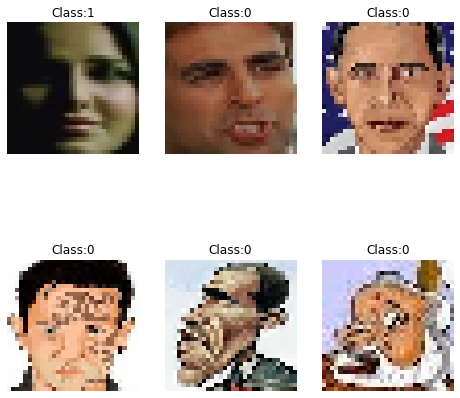

In [39]:
# Load data

new_dict = {'Amitabhbachan': 0,
    'AamirKhan': 0,
    'DwayneJohnson': 0,
    'AishwaryaRai': 1,
    'BarackObama': 0,
    'NarendraModi': 0,
    'ManmohanSingh': 0,
    'VladimirPutin': 0,
    'MadhuriDixit': 1,
    'Kajol': 1,
    'SharukhKhan': 0,
    'ShilpaShetty': 1,
    'AmitabhBachan': 0,
    'KatrinaKaif': 1,
    'AkshayKumar': 0,
    'Amir': 0}

dir_path = './dataset/IIIT-CFW/'
image_list = []
y_list=[]
for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = new_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
dir_path = './dataset/IMFDB/'
for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = new_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
            
X = np.array(image_list)
y = np.array(y_list)

print(X.shape, y.shape)
ind = np.random.randint(0,y.shape[0],6)
print("Some Example Images: ")
disply_images(X[ind,...],y[ind], row=2,col=3)


In [40]:
# Define your features

N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

#resnet + LR
cfw_resnet = get_resnet_features('./dataset/IIIT-CFW/')
imfdb_resnet = get_resnet_features('./dataset/IMFDB/')
X_proj = np.concatenate((cfw_resnet, imfdb_resnet))
X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y, test_size=0.33, random_state=42)

In [41]:
# Create your classifier
class NewClassifier():
    def __init__(self):
#         super.__init__()
        self.classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')   

    # Define your parameters eg, W,b, max_iterations etc.
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
            
        """
        
        prediction = self.classifier.predict(X)
        
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = confusion_matrix(pred, y)
        return cm
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        return self.classifier.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        
        # Create a confusion matrix
        y_pred = self.classifier.predict(X_validate)
        
        cm = confusion_matrix(y_pred, y_validate)
        
        # Calculate Validation accuracy 
        diagonal_sum = cm.trace()
        sum_of_all_elements = cm.sum()
        accuracy = diagonal_sum / sum_of_all_elements
        
        # Calculate precision and recall 
        precision = precision_score(y_validate, y_pred, average=None) 
        recall = recall_score(y_validate, y_pred, average=None)  
        
        # Calculate F1-score
        f1score = f1_score(y_validate, y_pred, average='weighted')
        
        verify = y_pred == y_validate
    
        return cm, accuracy, precision, recall, f1score, verify

c = NewClassifier()
c.train(X_proj_train, y_train)

# Validate your classifier
_, a,precision, recall, f1, bool_array = c.validate(X_proj_test, y_test)
print(X_proj_test.shape)

(354, 2048)


/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [42]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc. 
print("Accuracy: {}%".format(a*100))



Accuracy: 98.30508474576271%


In [43]:
from sklearn.model_selection import KFold

val_accuracy = []
k_fold_validation = KFold(n_splits=15)
for train_set, test_set in k_fold_validation.split(X_proj):
    c.train(X_proj[train_set], y[train_set])
    _, a, precision, recall, f1, v = c.validate(X_proj[test_set], y[test_set])
    val_accuracy.append(a)

val = np.array(val_accuracy)
validation_accuracy = np.mean(val)
print("KFold Validation Accuracy: " + str(validation_accuracy*100) +"%")

/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-define

KFold Validation Accuracy: 88.89019300991133%


/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


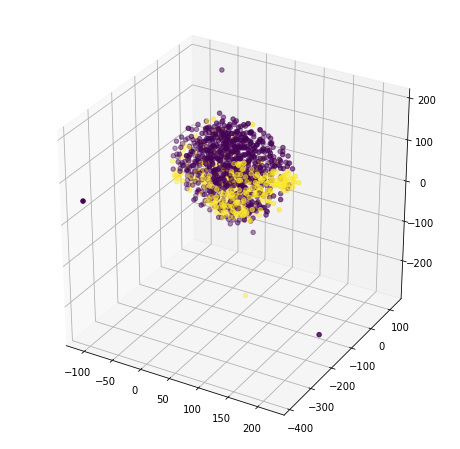

In [44]:
#TSNE
tsne_X = X.reshape((N,H*W*C))# feature 
k = 3 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components = k).fit_transform(tsne_X)

# X_train, X_test, y_train, y_test = train_test_split(X_TSNE, y)
# Plot the representation in 2d/3d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], X_TSNE[:,2],c=y)
plt.show()

/home/sagrika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Correct Classification Examples: 


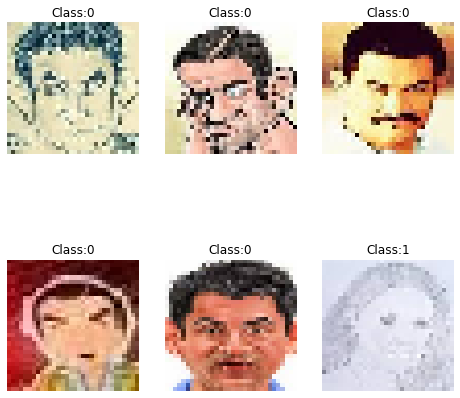

Wrong Classification Examples: 


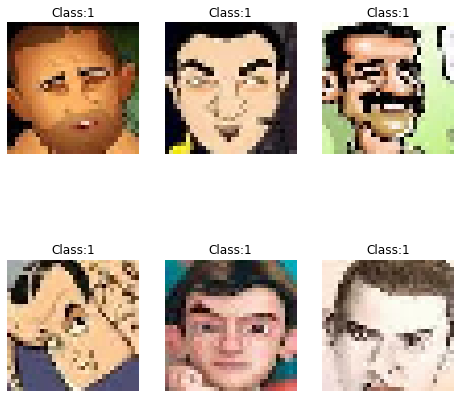

In [45]:
# Show quantitative results such as examples of correct prediction and wrong prediction

k_fold_validation = KFold(n_splits=2)
train_set, test_set  = k_fold_validation.split(X_proj)
c.train(X_proj[train_set[:1]], y[train_set[:1]])
_, a, precision, recall, f1, v = c.validate(X_proj[test_set[:1]], y[test_set[:1]])
correct = np.where(v == True)[0]
wrong = np.where(v == False)[0]
print('Correct Classification Examples: ')
disply_images(X[test_set[:1]][correct[:6]].reshape((6, 32, 32, 3)), y[test_set[:1]][correct[:6]], row=2, col=3)
if len(wrong) > 6:
    print('Wrong Classification Examples: ')
    X_wrong = X[test_set[:1]][wrong[:6]].reshape((6, 32, 32, 3))
    disply_images(X_wrong, 1 - y[test_set[:1]][wrong[:6]], row=2, col=3)


As can be seen from the accuracies and t-sne plot, we can see that the classifier works really well on the resnet features of the dataset created for this case. 